In [1]:
from pta_replicator.white_noise import add_measurement_noise
from pta_replicator.white_noise import add_jitter
from pta_replicator.red_noise import add_red_noise, add_gwb

from pta_replicator.simulate import load_pulsar, load_from_directories
from pta_replicator.simulate import make_ideal
import pint
import sys
import json
import numpy as np

import matplotlib.pyplot as plt

pint.logging.setup(sink=sys.stderr, level="WARNING", usecolors=True)

%load_ext autoreload
%autoreload 2

### First load pulsars either one at a time or from a directory of `par` and `tim` files

In [2]:
# One at a time
parfile = '../test_partim/par/B1855+09.par'
timfile = '../test_partim/tim/B1855+09.tim'

psr = load_pulsar(parfile, timfile)

In [3]:
# From a directory
pardir = '../test_partim/par'
timdir = '../test_partim/tim'

psrs = load_from_directories(pardir, timdir, num_psrs=2)  # Load 2 pulsars

### Load a noise dictionary with median values for the NANOGrav 15 year dataset and parse it

In [4]:
with open('../noise_dicts/ng15_dict.json', 'r') as fp:
    noise_params = json.load(fp)
# change number strings to floats:
for value in noise_params.values():
    value = float(value)

In [21]:
psrlist = [psr.name for psr in psrs]
noise_dict = {}
for p in psrlist:
    noise_dict[p] = {}
    noise_dict[p]['log10_equads'] = []
    noise_dict[p]['efacs'] = []
    noise_dict[p]['log10_ecorrs'] = []
    for ky in list(noise_params.keys()):
        if p in ky:
            if 'equad' in ky:
                noise_dict[p]['log10_equads'].append([ky.replace(p + '_' , '').replace('_log10_t2equad', ''), noise_params[ky]])
            if 'efac' in ky:
                noise_dict[p]['efacs'].append([ky.replace(p + '_' , '').replace('_efac', ''), noise_params[ky]])
            if 'ecorr' in ky:
                noise_dict[p]['log10_ecorrs'].append([ky.replace(p + '_' , '').replace('_log10_ecorr', ''), noise_params[ky]])
            if 'gamma' in ky:
                noise_dict[p]['rn_gamma'] = noise_params[ky]
            if 'log10_A' in ky:
                noise_dict[p]['rn_log10_amp'] = noise_params[ky]
                
    noise_dict[p]['log10_equads'] = np.array(noise_dict[p]['log10_equads'])
    noise_dict[p]['efacs'] = np.array(noise_dict[p]['efacs'])
    noise_dict[p]['log10_ecorrs'] = np.array(noise_dict[p]['log10_ecorrs'])

### Add noise signals to the pulsars

In [22]:
## By using seeds we can  reproduce the dataset if need be. 
seed_efac_equad = 10660
seed_jitter = 17763
seed_red = 19870
seed_gwb = 16672

In [24]:
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    ## add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr, efac = noise_dict[psr.name]['efacs'][:,1].astype(float),
                          log10_equad = noise_dict[psr.name]['log10_equads'][:,1].astype(float), 
                          flagid = 'f', flags = noise_dict[psr.name]['efacs'][:,0], 
                          seed = seed_efac_equad + ii)

    ## add jitter
    add_jitter(psr, log10_ecorr = noise_dict[psr.name]['log10_ecorrs'][:,1].astype(float), 
                flagid='f', flags = noise_dict[psr.name]['log10_ecorrs'][:,0], 
                coarsegrain = 1.0/86400.0, seed = seed_jitter + ii)

    ## add red noise
    add_red_noise(psr,
                  log10_amplitude = noise_dict[psr.name]['rn_log10_amp'],
                  spectral_index = noise_dict[psr.name]['rn_gamma'],
                  components = 30, seed = seed_red + ii)

    print(ii, psr.name)

0 B1855+09
1 B1937+21


### Finally, inject a GWB

In [27]:
add_gwb(psrs, log10_amplitude = -15, spectral_index = 13./3., seed = seed_gwb)

### Check the signals that we've injected

In [28]:
for psr in psrs:
    print(psr.added_signals)

{'B1855+09_430_ASP_measurement_noise': {'efac': 1.115935306813982, 'log10_t2equad': -7.564164330699591}, 'B1855+09_430_PUPPI_measurement_noise': {'efac': 1.000049037085653, 'log10_t2equad': -6.572540211467256}, 'B1855+09_L-wide_ASP_measurement_noise': {'efac': 1.043114017270374, 'log10_t2equad': -6.517929916655293}, 'B1855+09_L-wide_PUPPI_measurement_noise': {'efac': 1.1118432332882, 'log10_t2equad': -7.755603780476984}, 'B1855+09_430_ASP_jitter': {'log10_ecorr': -6.798122106550257}, 'B1855+09_430_PUPPI_jitter': {'log10_ecorr': -5.6989064141929715}, 'B1855+09_L-wide_ASP_jitter': {'log10_ecorr': -6.120457109433745}, 'B1855+09_L-wide_PUPPI_jitter': {'log10_ecorr': -6.641667916624413}, 'B1855+09_red_noise': {'amplitude': -14.037498114113964, 'spectral_index': 4.571208636529809}, 'B1855+09_gwb': {'amplitude': -15, 'spectral_index': 4.333333333333333}}
{'B1937+21_L-wide_ASP_measurement_noise': {'efac': 2.584236583895852, 'log10_t2equad': -7.240258825889674}, 'B1937+21_L-wide_PUPPI_measureme

B1855+09


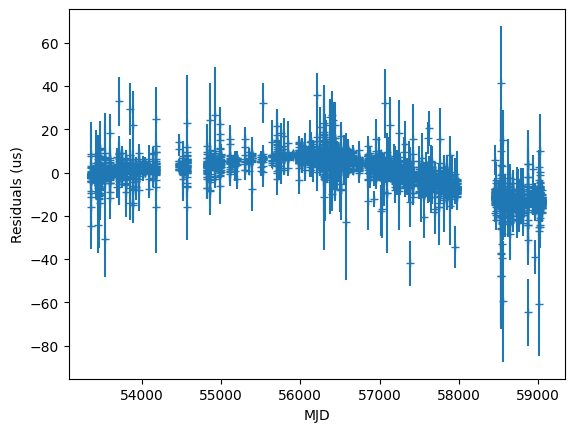

B1937+21


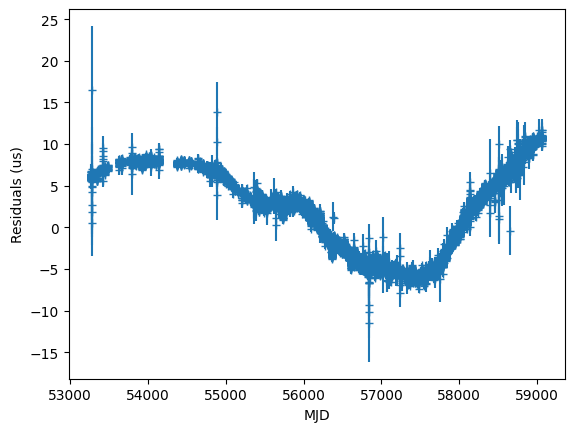

<Figure size 640x480 with 0 Axes>

In [38]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()
    plt.clf()